In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import seaborn as sns
from scipy import stats

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

In [2]:
def tif2array(file_path, dtype=np.uint8):
    """
    read GeoTiff and convert to numpy.ndarray.
    inputs:
        file_path (str) : file path of the input GeoTiff file
    return:
        image(np.array) : image for each bands
        dataset : for gdal's data drive
    """
    dataset = gdal.Open(file_path, gdal.GA_ReadOnly)

    if dataset is None:
        return None

    # Allocate our array using the first band's datatype
    image_datatype = dataset.GetRasterBand(1).DataType
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=dtype)

    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        image[:, :, b] = band.ReadAsArray()#buf_type=gdalconst.GDT_Byte)

    #image = image[2:-2,2:-2,:]

    return image

In [3]:
def array2raster(newRasterfn, dataset, array, dtype, offsetX=0, offsetY=0):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset : original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
    originX += offsetX
    originY += offsetY

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Int16":
        GDT_dtype = gdal.GDT_Int16
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    # setteing srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

## Phenology SOS - MOS - EOS - LOS

### Calculate phenology anomalies of Georgia

In [145]:
# set phenology type (key)
pheno_key = 'SOS'
calc_type = '{}_diff_std'.format(pheno_key.lower())

# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth_eos.h5'
# read hdf5 file
hdf5_modis = h5py.File(path_hdf5, 'r')

(1299, 1864)


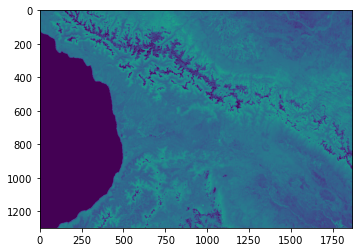

In [146]:
# calculate mean
mean = np.mean(hdf5_modis[pheno_key][:,:,1:], axis=2)
# calculate standard deviation
std = np.std(hdf5_modis[pheno_key][:,:,1:], axis=2)

# calculate maximum
maxi = np.max(hdf5_modis[pheno_key][:,:,1:], axis=2)
# calculate minimum
mini = np.min(hdf5_modis[pheno_key][:,:,1:], axis=2)

# show image and its size
print(mean.shape)
plt.imshow(mean)

/tmp/ipykernel_10847/636875429.py:2: RuntimeWarning: invalid value encountered in true_divide
  anom_rel = (hdf5_modis[pheno_key][:,:,9] - mini) / (maxi - mini) * 100
/tmp/ipykernel_10847/636875429.py:3: RuntimeWarning: invalid value encountered in true_divide
  anom_std = (hdf5_modis[pheno_key][:,:,9] - mini) / (maxi - mini) * 100


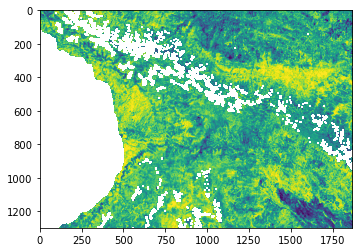

In [10]:
# test to calculate anomalies
anom_abs = hdf5_modis[pheno_key][:,:,9] - mean
anom_rel = (hdf5_modis[pheno_key][:,:,9] - mini) / (maxi - mini) * 100
anom_std = (hdf5_modis[pheno_key][:,:,9] - mini) / (maxi - mini) * 100
plt.imshow(anom_std)

In [13]:
# Calculate anomalies for 2010 - 2020 and write as tif-files

for i in range(1, 12):
    # create input path
    path_in = '/home/philipp/Data/modis/raw/MOD13Q1.A2009001.250m_16_days_NDVI.tif'
    # create output path
    path_out = '/home/philipp/Data/modis/sos/georgia_{}_{}.tif'.format(calc_type, 2009+i)
    # open coresponding ortho file
    dataset = gdal.Open(path_in, gdal.GA_ReadOnly)
    
    if calc_type[4:] == 'diff_abs':
        data = hdf5_modis[pheno_key][:,:,i] - mean
    elif calc_type[4:] == 'diff_rels':
        data = (hdf5_modis[pheno_key][:,:,i] - mini) / (maxi - mini) * 100
    elif calc_type[4:] == 'diff_std':
        data = (hdf5_modis[pheno_key][:,:,i] - mean) / std
    else:
        break
        
    # create rater (GeoTiff) file out of numpy array (prediction) and coresponding ortho file information  
    array2raster(newRasterfn=path_out, dataset=dataset, array=data, dtype='Int16', offsetX=0, offsetY=0)

print('finished')

del data

/tmp/ipykernel_10847/12560020.py:15: RuntimeWarning: invalid value encountered in true_divide
  data = (hdf5_modis[pheno_key][:,:,i] - mean) / std
ERROR 1: PROJ: createGeodeticReferenceFrame: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: createGeodeticReferenceFrame: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: pro

finished


ERROR 1: PROJ: createGeodeticReferenceFrame: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: createGeodeticReferenceFrame: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/co

In [14]:
# write mean to tif-file
calc_type = '{}_mean'.format(pheno_key.lower())

# create input path
path_in = '/home/philipp/Data/modis/raw/MOD13Q1.A2009001.250m_16_days_NDVI.tif'
# create output path
path_out = '/home/philipp/Data/modis/sos/georgia_{}.tif'.format(calc_type)
# open coresponding ortho file
dataset = gdal.Open(path_in, gdal.GA_ReadOnly)

# create rater (GeoTiff) file out of numpy array (prediction) and coresponding ortho file information  
array2raster(newRasterfn=path_out, dataset=dataset, array=mean, dtype='Int16', offsetX=0, offsetY=0)

ERROR 1: PROJ: createGeodeticReferenceFrame: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /home/philipp/software/conda3/envs/modis/share/proj failed


### Compare phenology of diffrent land cover types

In [10]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth_eos.h5'
# read hdf5 file
hdf5_modis = h5py.File(path_hdf5, 'r')

# read land cover data
file_path = "/home/philipp/Data/modis/aligned/georgia_region/lc_2019.tif"
lc = tif2array(file_path, dtype=np.int16)
# read mask for Georgia
file_path = "/home/philipp/Data/modis/aligned/georgia_clipped/mask.tif"
mask = tif2array(file_path, dtype=np.int8)

# fiter data for Georgia
lc_geo = lc * mask

In [21]:
lc_dict = {20:'Shrubs', 30:'Herbaceous vegetation', 40:'Cropland', 50:'Urban', 60:'Bare',\
 70:'Snow and Ice', 80:'Water', 90:'Herbaceous wetland', 100:'Moss and lichen',\
111:'Closed forest, evergreen needle leaf',\
114:'Closed forest, deciduous broad leaf',\
115:'Closed forest, mixed',\
116:'Closed forest, unknown',\
126:'Open forest, unknown'}

In [11]:
u, c = np.unique(lc_geo, return_counts=True)
print(u)
print(c)

[  0  20  30  40  50  60  70  80  90 100 111 114 115 116 121 124 125 126
 200]
[1417647    4620  271432  152469   17094   12078    7552    3659    3228
       4   44277  318365   15365   48605     585    8569      48   59970
     696]


In [20]:
# rearange phenology data

pheno_types = {}

for pheno_key in ['SOS','MOS','EOS']:

    pheno = []

    # loop all years (2010 - 2020)
    for i in range(1,12):
        pheno.append(hdf5_modis[pheno_key][:,27:,i].flatten())

    pheno = np.array(pheno)

    print(pheno.shape)
    
    lc_types = np.array([ 30, 40, 50, 111, 114, 115, 116, 126])

    pheno_type = {}

    # loop over all types
    for lc_type in lc_types:
        # get indices that mach a specific type
        idxs = np.where(lc_geo.flatten()==lc_type)[0]
        # filter for specific lc type
        #pheno_idxs = pheno[:,idxs]
        # append data for lc type
        pheno_type[lc_type] = pheno[:,idxs]
        
    pheno_types[pheno_key] = pheno_type

(11, 2386263)
(11, 2386263)
(11, 2386263)


In [21]:
pheno_types

{'SOS': {30: array([[ -1,  -1,  -1, ...,  60,  57,  57],
         [ -1,  -1,  -1, ...,  67,   6,  66],
         [ -1,  -1,  -1, ...,  52,  48,  51],
         ...,
         [ -1,  -1,  -1, ...,  44,  44,  31],
         [138, 138,  -1, ...,  29,  30,  29],
         [ -1, 136, 144, ...,  55,  66,  74]], dtype=int16),
  40: array([[ 72,  98,  85, ...,  50,  50,  43],
         [ 90, 106,  93, ...,  69,  68,  63],
         [ 80,  74,  79, ...,  59,  50,  72],
         ...,
         [ 60,  72,  57, ...,  40,  40,  34],
         [ 77,  79,  73, ...,  33,  31,  30],
         [ 75,  77,  50, ...,  74,  84,  76]], dtype=int16),
  50: array([[ 79,  79,  84, ...,  68,  80,  69],
         [ 93, 102, 104, ...,  70,  88,  84],
         [ 78,  78,  67, ...,  72,  76,  75],
         ...,
         [ 74,  74,  95, ...,  48,  65,  66],
         [ 75,  81,  72, ...,  65,  76,  78],
         [ 75,  76,  80, ...,  95,  75,  76]], dtype=int16),
  111: array([[56, 59, 79, ..., 76, 62,  3],
         [66, 81, 83,

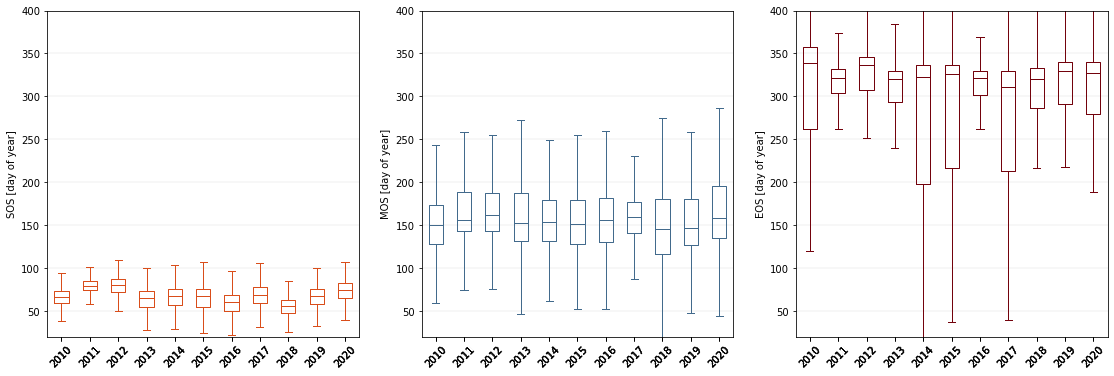

In [40]:
lc_type = 40

# Filter no value data (convert to list since no value data is no the same every year)
filtered_data = {}
for t in ['SOS', 'MOS', 'EOS']:
    data = pheno_types[t][lc_type]
    mask = data > 0
    filtered_data[t] = [d[m] for d, m in zip(data, mask)]

# set color
colors_setosa = [dict(color='#D94D1A'), dict(color='#426A8C'), dict(color='#73020C')]

# create plot
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(19, 6))

for i, t in enumerate(['SOS', 'MOS', 'EOS']):
    
    ax[i].boxplot(filtered_data[t], showfliers=False, boxprops=colors_setosa[i], medianprops=colors_setosa[i],\
               whiskerprops=colors_setosa[i], capprops=colors_setosa[i], flierprops=colors_setosa[i],\
               labels = range(2010,2021))
    ax[i].tick_params(axis='x', labelrotation = 45)
    # specify labels
    ax[i].set_ylabel('{} [day of year]'.format(t))
    # set range
    ax[i].set_ylim([20, 400])
    # Add major gridlines in the y-axis
    ax[i].grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

plt.show()

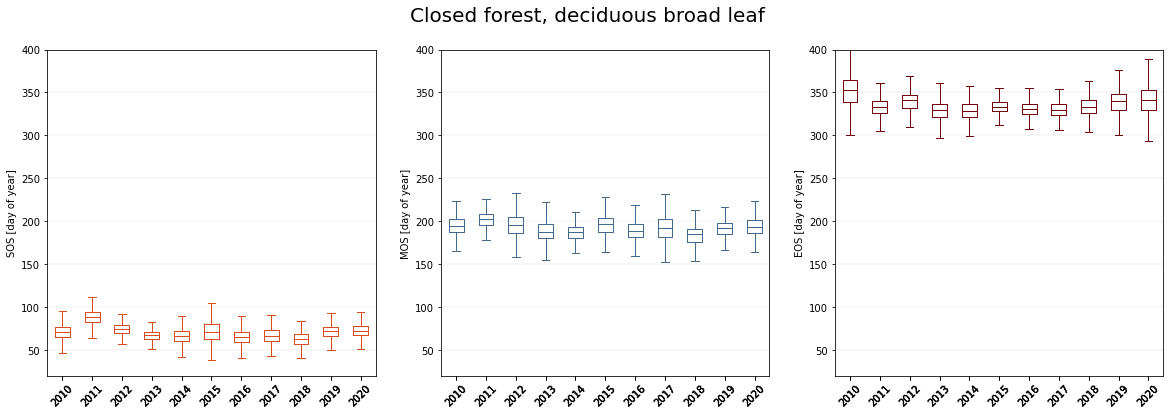

In [170]:
lc_type = 114

# Filter no value data (convert to list since no value data is no the same every year)
filtered_data = {}
for t in ['SOS', 'MOS', 'EOS']:
    data = pheno_types[t][lc_type]
    mask = data > 0
    filtered_data[t] = [d[m] for d, m in zip(data, mask)]

# set color
colors_setosa = [dict(color='#D94D1A'), dict(color='#426A8F'), dict(color='#73020C')]

# create plot
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(20, 6))

for i, t in enumerate(['SOS', 'MOS', 'EOS']):
    
    ax[i].boxplot(filtered_data[t], showfliers=False, boxprops=colors_setosa[i], medianprops=colors_setosa[i],\
               whiskerprops=colors_setosa[i], capprops=colors_setosa[i], flierprops=colors_setosa[i],\
               labels = range(2010,2021))
    ax[i].tick_params(axis='x', labelrotation = 45)
    # specify labels
    ax[i].set_ylabel('{} [day of year]'.format(t))
    # Add major gridlines in the y-axis
    ax[i].grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    ax[i].set_ylim([20, 400])
    
fig.suptitle(lc_dict[lc_type], fontsize=20)

plt.savefig('/home/philipp/Data/modis/graphs/{}.png'.format(lc_type), dpi=300)
plt.show()

In [100]:
range(len(filtered_data[t]))

range(0, 11)

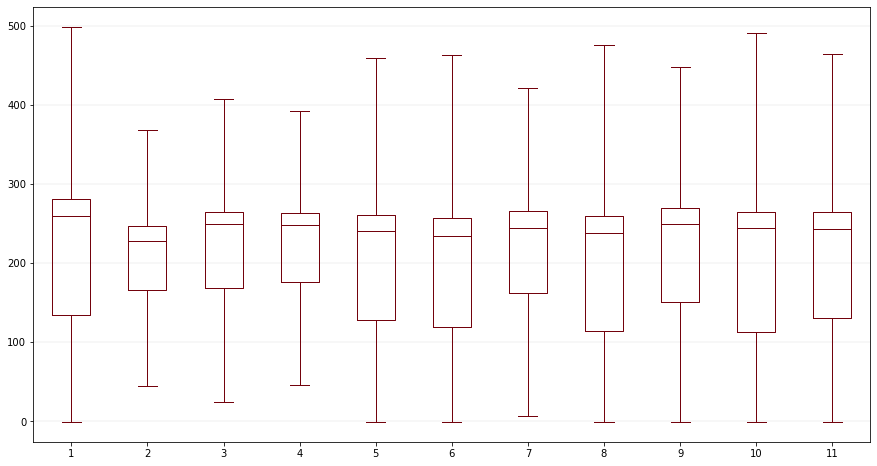

In [165]:
colors_setosa = dict(color='#73020C')
                            # #73020C, '#426A8C', '#D94D1A'])

ig, ax = plt.subplots(figsize=(15, 8))

ax.boxplot(np.transpose(sos_111), showfliers=False, boxprops=colors_setosa, medianprops=colors_setosa, whiskerprops=colors_setosa, capprops=colors_setosa, flierprops=colors_setosa)
# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

plt.show()

### Altitude

In [141]:
file_path = "/home/philipp/Data/modis/aligned/georgia_region/lc_2019.tif"
lc = tif2array(file_path, dtype=np.int16)
file_path = "/home/philipp/Data/modis/aligned/georgia_region/koeppen.tif"
koeppen = tif2array(file_path, dtype=np.int16)
file_path = "/home/philipp/Data/modis/aligned/georgia_region/dem.tif"
dem = tif2array(file_path, dtype=np.int16)

file_path = "/home/philipp/Data/modis/aligned/georgia_clipped/mask.tif"
mask = tif2array(file_path, dtype=np.int8)

file_path = '/home/philipp/Data/modis/sos/georgia_sos_mean.tif'
mean = tif2array(file_path, dtype=np.int16)

In [142]:
np.unique(dem)

array([ -23,  -21,  -16, ..., 5582, 5592, 5597], dtype=int16)

In [143]:
print(mean[:,27:].shape)
print(dem.shape)
print(mask.shape)

(1299, 1837, 1)
(1299, 1837, 1)
(1299, 1837, 1)


In [153]:
x.shape

(1219848,)

In [156]:
x[x>0].shape

(841466,)

In [159]:
x

array([71.54545455, 70.63636364, 70.81818182, ..., 65.45454545,
       68.27272727, 57.27272727])

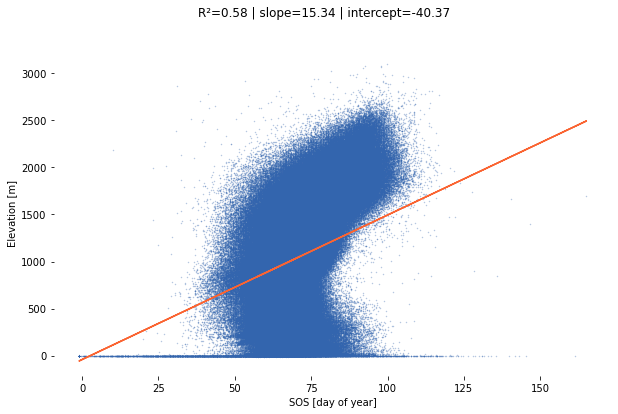

In [173]:
# filter just forest
idxs_forst = np.where(lc.flatten()>100)

# set SOS
x = mean[:,27:].flatten()[idxs_forst]
# set DEM
y = dem.flatten()[idxs_forst]

#y = y[x>0]
#x = x[x>0]

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, alpha=0.4, s=0.2, color='#3365AE')

ax.set_ylabel('Elevation [m]')
ax.set_xlabel('SOS [day of year]')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color='#FA6432')

slope, intercept, r, p, std_err = stats.linregress(x, y)

fig.suptitle('R²={} | slope={} | intercept={}'.format(round(r**2, 2), round(slope, 2),round(intercept, 2)), fontsize=12)
#ax.annotate('figure points', xy=(80, 80), xycoords='figure points')

plt.savefig('/home/philipp/Data/modis/graphs/elev.png', dpi=300)

In [121]:
slope, slope, r, p, std_err = stats.linregress(x, y)
r

0.759638686159795

## NDVI

In [4]:
# read land cover data
file_path = "/home/philipp/Data/modis/aligned/georgia_region/lc_2019.tif"
lc = tif2array(file_path, dtype=np.int16)
# read mask for Georgia
file_path = "/home/philipp/Data/modis/aligned/georgia_clipped/mask.tif"
mask = tif2array(file_path, dtype=np.int8)

# fiter data for Georgia
lc_geo = lc * mask

In [5]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_lc_types.h5'

hdf5_modis_lc = h5py.File(path_hdf5, 'r')

In [5]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth.h5'

ndvi = h5py.File(path_hdf5, 'r')

In [6]:
####

In [7]:
lc_geo = lc_geo.flatten()

In [8]:
for t in np.unique(lc_geo)[1:]:
    print(t, lc_geo[lc_geo==t].size)

20 4620
30 271432
40 152469
50 17094
60 12078
70 7552
80 3659
90 3228
100 4
111 44277
114 318365
115 15365
116 48605
121 585
124 8569
125 48
126 59970
200 696


In [9]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_lc_types.h5'

# create / open file
hdf5_modis_lc = h5py.File(path_hdf5, 'a')

if not os.path.isfile(path_hdf5):
    print('file not found -> creating file')

for lc_type in np.unique(lc_geo)[1:]:
    # create dataset
    hdf5_modis_lc.create_dataset('y'+str(lc_type), (lc_geo[lc_geo==lc_type].size, 365*11), dtype=np.float16)

In [52]:
for lc_type in np.unique(lc_geo)[1:]:
    # create dataset
    hdf5_modis_lc.create_dataset('y'+str(lc_type), (lc_geo[lc_geo==lc_type].size*11, 365), dtype=np.float16)

In [54]:
# get indices of lc types
idxs = {}
for lc_type in np.unique(lc_geo)[1:]:
    idxs[str(lc_type)] = np.where(lc_geo.flatten()==lc_type)[0]

In [40]:
def ndvi_year(ndvi, ndvi_lc, idxs, year):
    i = year - 2009
    
    # get one year of ndvi data
    ndvi_year = ndvi['whittaker'][:,27:,365*i:365*(i+1)]
    # reshape ndvi data
    ndvi_year = np.reshape(ndvi_year, (-1,365))
    
    for lc_type in idxs:
        # add to hdf5 file
        ndvi_lc[lc_type][:,365*(i-1):365*i] = ndvi_year[idxs[lc_type],:]
    
    #return ndvi_year

In [59]:
def ndvi_mean_year(ndvi, ndvi_lc, idxs, year):
    i = year - 2009
    
    # get one year of ndvi data
    ndvi_year = ndvi['whittaker'][:,27:,365*i:365*(i+1)]
    # reshape ndvi data
    ndvi_year = np.reshape(ndvi_year, (-1,365))
    
    for lc_type in idxs:
        s = idxs[lc_type].size
        # add to hdf5 file
        ndvi_lc['y'+lc_type][s*(i-1):s*i,:] = ndvi_year[idxs[lc_type],:]

In [60]:
for year in range(2010,2021):
    ndvi_mean_year(ndvi, hdf5_modis_lc, idxs, year)

In [62]:
hdf5_modis_lc['y114'][:]

(3502015, 365)

In [58]:
idxs['20'].size

4620

In [12]:
ndvi_2010 = ndvi_2010[ndvi_2010!=0]

In [13]:
ndvi_2010.shape

(353543745,)

In [ ]:
ndvi_all = []

for i in range(1,12):
    ndvi_all.append(ndvi['whittaker'][:,27:,365*i:365*(i+1)])
    
ndvi_all = np.concatenate(ndvi_all, axis=2)

In [ ]:
ndvi_all.shape

In [9]:
ndvi_2010 = ndvi['whittaker'][:,27:,365:365*2]

In [10]:
ndvi_2010.shape

(1299, 1837, 365)

In [13]:
ndvi_2010 = np.reshape(ndvi_2010, (-1,365))

In [14]:
ndvi_2010.shape

(2386263, 365)

In [15]:
lc_types = np.unique(lc)
lc_types

array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 111, 114, 115, 116,
       121, 124, 125, 126, 200], dtype=int16)

#### forest

In [16]:
lc_types = np.array([ 111, 114, 115, 116, 121, 124, 125, 126])

In [17]:
ndvi_mean = {}

for lc_type in lc_types:
    idxs = np.where(lc.flatten()==lc_type)
    
    ndvi_mean[lc_type] = np.mean(ndvi_2010[idxs], axis=0)

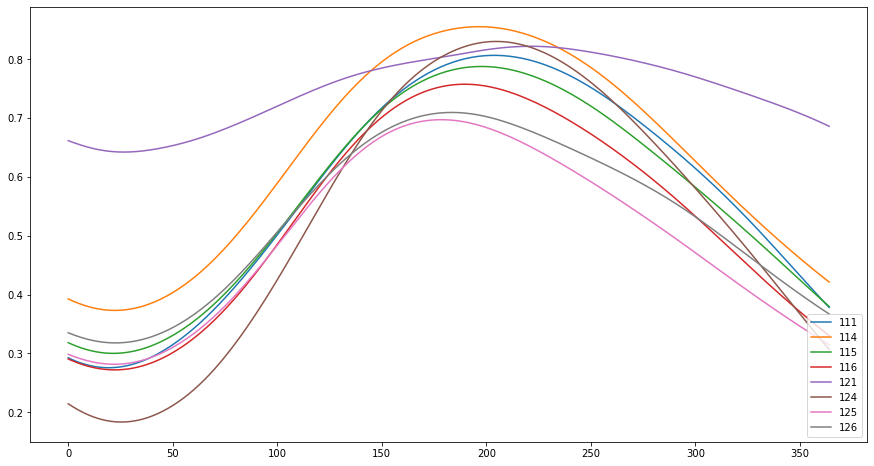

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))

for lc_type in lc_types:
    ax.plot(ndvi_mean[lc_type], label=str(lc_type))

ax.legend(loc='lower right')

#### lc types

In [19]:
lc_types = np.array([20,  30,  40,  50,  60,  70,  80,  90, 100, 200])

In [20]:
ndvi_mean = {}

for lc_type in lc_types:
    idxs = np.where(lc.flatten()==lc_type)
    
    ndvi_mean[lc_type] = np.mean(ndvi_2010[idxs], axis=0)

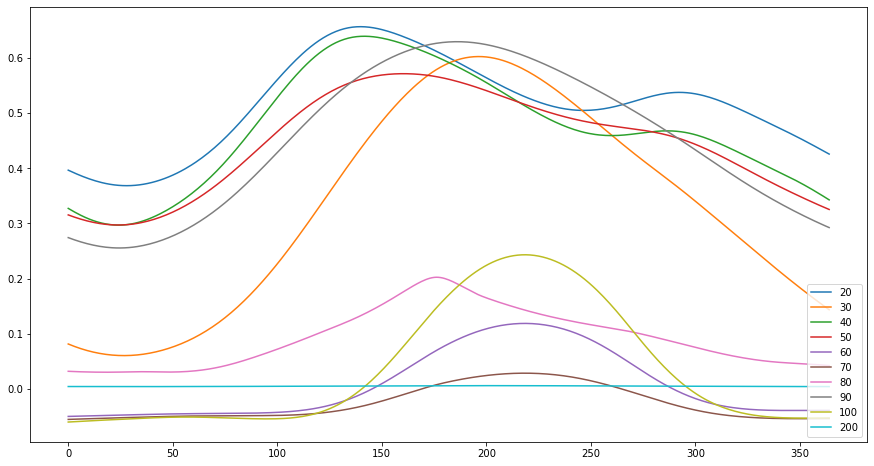

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))

for lc_type in lc_types:
    ax.plot(ndvi_mean[lc_type], label=str(lc_type))

ax.legend(loc='lower right')

In [90]:
#ndvi_min = {}
ndvi_mean = {}
ndvi_std = {}

#for lc_type in [30,40,114]:
for lc_type in [111, 114, 126]:
#for lc_type in [50, 60, 70, 80]:
    idxs = np.where(lc.flatten()==lc_type)

    ndvi_mean[lc_type] = np.mean(hdf5_modis_lc['y'+str(lc_type)][:], axis=0)
    ndvi_std[lc_type] = np.std(hdf5_modis_lc['y'+str(lc_type)][:], axis=0)

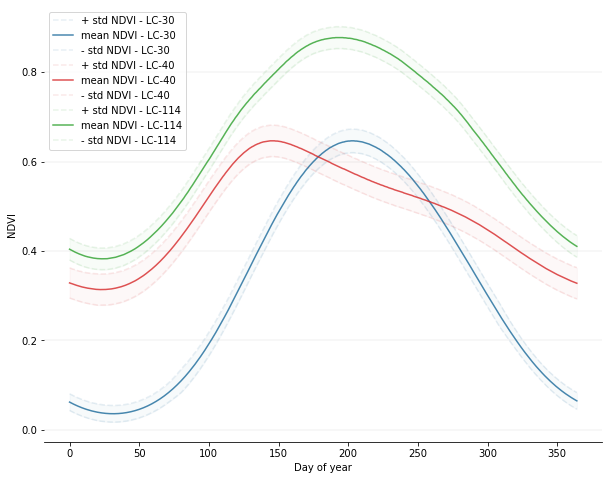

In [87]:
fig, ax = plt.subplots(figsize=(10, 8))

#colors = ['#73020C', '#426A8C', '#D94D1A']
colors = ['#1A699A', '#d62728', '#2ca02c']

for col_idx, lc_type in enumerate([30,40,114]):

    ax.plot(ndvi_mean[lc_type]+ndvi_std[lc_type], label='+ std NDVI - LC-'+str(lc_type), color=colors[col_idx], ls='--', alpha=0.1)
    ax.plot(ndvi_mean[lc_type], label='mean NDVI - LC-'+str(lc_type), color=colors[col_idx], alpha=0.8)
    ax.plot(ndvi_mean[lc_type]-ndvi_std[lc_type], label='- std NDVI - LC-'+str(lc_type), color=colors[col_idx], ls='--', alpha=0.1)
    
    ax.fill_between(np.arange(0,365), ndvi_mean[lc_type]+ndvi_std[lc_type],\
                    ndvi_mean[lc_type]-ndvi_std[lc_type], alpha=0.03, color=colors[col_idx])
    
    ax.set_ylabel('NDVI')
    ax.set_xlabel('Day of year')
    
    # Add major gridlines in the y-axis
    ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

ax.legend(loc='upper left')
plt.savefig('/home/philipp/Data/modis/graphs/NDVI_mean_main_108.png', dpi=300)

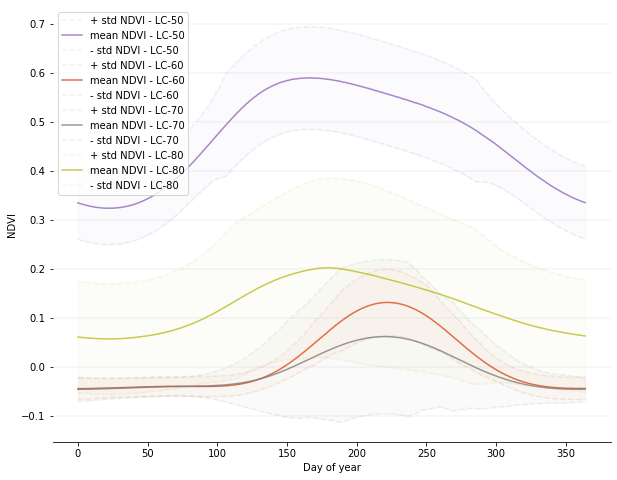

In [89]:
fig, ax = plt.subplots(figsize=(10, 8))

#colors = ['#73020C', '#426A8C', '#D94D1A']
colors = ['#9467bd', '#D94D1A', '#7f7f7f', '#bcbd22', '#17becf', '#426A8C', '#D94D1A', '#e377c2']

for col_idx, lc_type in enumerate([50, 60, 70, 80]):

    ax.plot(ndvi_mean[lc_type]+ndvi_std[lc_type], label='+ std NDVI - LC-'+str(lc_type), color=colors[col_idx], ls='--', alpha=0.1)
    ax.plot(ndvi_mean[lc_type], label='mean NDVI - LC-'+str(lc_type), color=colors[col_idx], alpha=0.8)
    ax.plot(ndvi_mean[lc_type]-ndvi_std[lc_type], label='- std NDVI - LC-'+str(lc_type), color=colors[col_idx], ls='--', alpha=0.1)
    
    ax.fill_between(np.arange(0,365), ndvi_mean[lc_type]+ndvi_std[lc_type],\
                    ndvi_mean[lc_type]-ndvi_std[lc_type], alpha=0.03, color=colors[col_idx])
    
    ax.set_ylabel('NDVI')
    ax.set_xlabel('Day of year')
    
    # Add major gridlines in the y-axis
    ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

ax.legend(loc='upper left')
plt.savefig('/home/philipp/Data/modis/graphs/NDVI_mean_add_108.png', dpi=300)

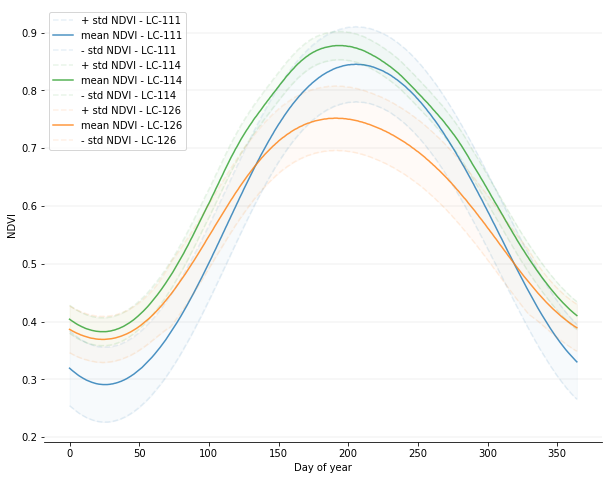

In [91]:
fig, ax = plt.subplots(figsize=(10, 8))

#colors = ['#73020C', '#426A8C', '#D94D1A']
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for col_idx, lc_type in enumerate([111, 114, 126]):

    ax.plot(ndvi_mean[lc_type]+ndvi_std[lc_type], label='+ std NDVI - LC-'+str(lc_type), color=colors[col_idx], ls='--', alpha=0.1)
    ax.plot(ndvi_mean[lc_type], label='mean NDVI - LC-'+str(lc_type), color=colors[col_idx], alpha=0.8)
    ax.plot(ndvi_mean[lc_type]-ndvi_std[lc_type], label='- std NDVI - LC-'+str(lc_type), color=colors[col_idx], ls='--', alpha=0.1)
    
    ax.fill_between(np.arange(0,365), ndvi_mean[lc_type]+ndvi_std[lc_type],\
                    ndvi_mean[lc_type]-ndvi_std[lc_type], alpha=0.03, color=colors[col_idx])
    
    ax.set_ylabel('NDVI')
    ax.set_xlabel('Day of year')
    
    # Add major gridlines in the y-axis
    ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

ax.legend(loc='upper left')
plt.savefig('/home/philipp/Data/modis/graphs/NDVI_mean_forest_108.png', dpi=300)